In [28]:
import os
import sys 
sys.path.append('../../utilities/')
import data_utils, evaluation_utils
sys.path.append('../../src')
from dataset_class import dataset
import pandas as pd
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from hmmlearn import hmm

signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
K562_dataset = dataset('K562', 'hg19', 100000, '',
                 '../../utilities/juicer_tools_1.22.01.jar', '../../data/K562/hg19/Hi-C/res100000',
                 signals_names, '../../data/K562/hg19/genomic-assays/bin_100000/', 
                  '../../data/K562/hg19/res100000_datasets/',
                  '../../data/', '../../utilities/config.json')
K562_dataset.load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/K562_100000_bins.txt')
#K562_dataset.generate_signals_and_bin_files()

In [29]:
K562_dataset.read_annotation('../../data/K562/hg19/annotations/K562_SNIPER.bed', 'SNIPER')
K562_dataset.read_annotation('../../data/K562/hg19/annotations/K562_segway_GBR.bed', 'segway_GBR')

In [3]:
TSA_signals = K562_dataset.valid_bins_df.copy()
Lamin_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/LaminA_TSA-seq.bedgraph', sep = "\t", header = None)
Lamin_df.columns = ['chr_name', 'start', 'end', 'LaminA']
TSA_signals = TSA_signals.merge(Lamin_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)
SON_df = pd.read_csv('../../data/K562/hg19/genomic-assays/bin_100000/SON_TSA-seq.bedgraph', sep = "\t", header = None)
SON_df.columns = ['chr_name', 'start', 'end', 'SON']
TSA_signals = pd.merge(TSA_signals, SON_df, on = ['chr_name', 'start', 'end'], how = 'left')
TSA_signals.drop_duplicates(subset=['index'], keep = 'first', inplace = True)

In [66]:
functional_signals_path = "../../data/K562/hg19/res100000_datasets/signals.txt"
functional_signals = np.arcsinh(np.loadtxt(functional_signals_path))

In [63]:
K562_dataset.labels['SNIPER']

array([None, 'A1', 'A1', ..., 'A1', 'A1', 'A1'], dtype=object)

# SCI graph

In [78]:
embeddings = {}
for d in [4,8,16,32,64]:
    for s in [1,5,10,50,100,200]:
        for o in [1,2]:
            file_path = '../../data/K562/hg19/res100000_datasets/embeddings/sci/sci_d{' + str(d) + '}_s{' + str(s) + '}_o{' + str(o) + '}.txt'
            embeddings[d,s,o] = K562_dataset.read_line_embedding(file_path, d, 0)

In [83]:
lengths = K562_dataset.get_chunks_lengths()
for d in [4,8,16,32,64]:
    for s in [1,5,10,50,100,200]:
        for o in [1,2]:
            structural_signals = np.array(embeddings[d,s,o].loc[:,['emb{}'.format(e) for e in np.arange(1,d+1)]])
            gmm_hmm_viterbi = hmm.GaussianHMM(n_components=5, covariance_type = 'full', algorithm='viterbi')
            gmm_hmm_viterbi.fit(structural_signals, lengths)
            l = gmm_hmm_viterbi.predict(structural_signals, lengths)
            embeddings[d,s,o]['HMM_structural'] = l

In [ ]:
for d in [4,8,16,32,64]:
    for s in [1,5,10,50,100,200]:
        for o in [1,2]:
            embeddings[d,s,o].to_csv('../../data/K562/hg19/res100000_datasets/embeddings/sci_processed/sci_d{}_s{}_o{}.txt'.format(d,s,o), sep = '\t', index = False)

In [111]:
Lamin_VE = []
for d in [4,8,16,32,64]:
    for s in [1,5,10,50,100,200]:
        for o in [1,2]:
            Lamin_ve = evaluation_utils.variance_explained(TSA_signals.iloc[:,4].values,
                                                embeddings[d,s,o]['HMM_structural'])
            Lamin_VE.append({'d': d, 's': s, 'o': o, 've': Lamin_ve})
Lamin_VE = pd.DataFrame(Lamin_VE)

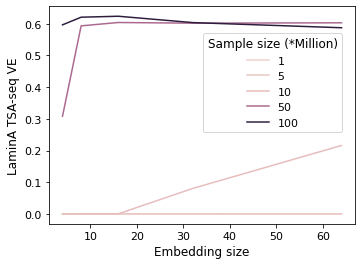

In [126]:
fig = plt.figure(figsize=(5.5,4))
ax = sns.lineplot(x="d", y="ve", hue="s", data=Lamin_VE[(Lamin_VE['o'] == 2) & (Lamin_VE['s']!=200)][['d','s','ve']])
ax.set_xlabel('Embedding size', size = 12)
ax.set_ylabel('LaminA TSA-seq VE', size = 12)
plt.legend(fontsize=11, title='Sample size (*Million)', title_fontsize = 12, 
           loc = 'center', bbox_to_anchor = [0.73, 0.65])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
fig.savefig(os.path.join('results/', "hyper_d_s(VE).png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [117]:
SI_df = []
for d in [4,8,16,32,64]:
    for s in [1,5,10,50,100]:
        SI = metrics.silhouette_score(embeddings[d,s,2][K562_dataset.labels['SNIPER'] != None][['emb{}'.format(e) for e in np.arange(1,d+1)]], 
                             K562_dataset.labels['SNIPER'][K562_dataset.labels['SNIPER'] != None], metric='euclidean')
        SI_df.append({'d':d, 's':s, 'SI':SI})
SI_df = pd.DataFrame(SI_df)

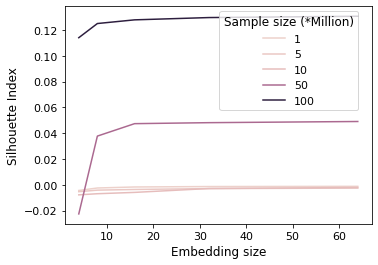

In [127]:
fig = plt.figure(figsize=(5.5,4))
ax = sns.lineplot(x="d", y="SI", hue="s", data=SI_df)
ax.set_xlabel('Embedding size', size = 12)
ax.set_ylabel('Silhouette Index', size = 12)
plt.legend(fontsize=11, title='Sample size (*Million)', title_fontsize = 12, 
           loc = 'center', bbox_to_anchor = [0.73, 0.75])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
fig.savefig(os.path.join('results/', "hyper_d_s.png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [129]:
first_embeddings = K562_dataset.read_line_embedding('../../data/K562/hg19/res100000_datasets/embeddings/sci/sci_d{8}_s{100}_o{1}.txt', 8, 0)

In [130]:
first_SI = metrics.silhouette_score(first_embeddings[K562_dataset.labels['SNIPER'] != None][['emb{}'.format(e) for e in np.arange(1,9)]], 
                             K562_dataset.labels['SNIPER'][K562_dataset.labels['SNIPER'] != None], metric='euclidean')

In [132]:
print(SI_df[(SI_df['s'] == 100) & (SI_df['d'] == 8)],first_SI)

   d    s        SI
9  8  100  0.125052 -0.3366060719409845


# O/E graph

In [4]:
lengths = K562_dataset.get_chunks_lengths()
embeddings = {}
for d in [2,4,8,16,32,64,128]:
    for s in [1,5,10,50,100]:
        file_path = '../../data/K562/hg19/res100000_datasets/embeddings/oe/oe_d{}_s{}_o{}.txt'.format(d,s,2)
        embeddings[d,s] = K562_dataset.read_line_embedding(file_path, d, 0)
        structural_signals = np.array(embeddings[d,s].loc[:,['emb{}'.format(e) for e in np.arange(1,d+1)]])
        gmm_hmm_viterbi = hmm.GaussianHMM(n_components=5, covariance_type = 'full', algorithm='viterbi')
        gmm_hmm_viterbi.fit(structural_signals, lengths)
        l = gmm_hmm_viterbi.predict(structural_signals, lengths)
        embeddings[d,s]['HMM_structural'] = l

In [6]:
for d in [2,4,8,16,32,64,128]:
    for s in [1,5,10,50,100]:
        embeddings[d,s].to_csv('../../data/K562/hg19/res100000_datasets/embeddings/oe_processed/oe_d{}_s{}_o{}.txt'.format(d,s,2), sep = '\t', index = False)

In [18]:
TSA_VE = []
for d in [2,4,8,16,32,64,128]:
    for s in [1,5,10,50,100]:
        LaminA_ve = evaluation_utils.variance_explained(TSA_signals.iloc[:,4].values,
                                                embeddings[d,s]['HMM_structural'])
        SON_ve = evaluation_utils.variance_explained(TSA_signals.iloc[:,5].values,
                                                embeddings[d,s]['HMM_structural'])
        TSA_VE.append({'d': d, 's': s, 'LaminA_ve': LaminA_ve, 'SON_ve': SON_ve})
TSA_VE = pd.DataFrame(TSA_VE)

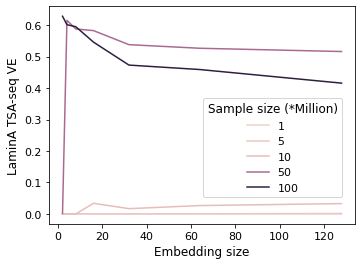

In [23]:
fig = plt.figure(figsize=(5.5,4))
ax = sns.lineplot(x="d", y="LaminA_ve", hue="s", data=TSA_VE)
ax.set_xlabel('Embedding size', size = 12)
ax.set_ylabel('LaminA TSA-seq VE', size = 12)
plt.legend(fontsize=11, title='Sample size (*Million)', title_fontsize = 12, 
           loc = 'center', bbox_to_anchor = [0.73, 0.35])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
fig.savefig(os.path.join('results/', "hyper_d_s(VE).png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

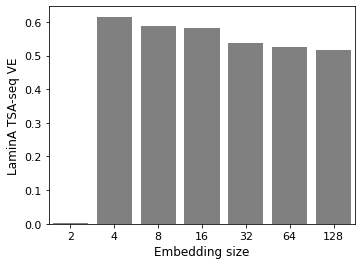

In [24]:
fig = plt.figure(figsize=(5.5,4))
ax = sns.barplot(data=TSA_VE[TSA_VE['s']==50], x = 'd', y = 'LaminA_ve', color = 'Grey')
ax.set_xlabel('Embedding size', size = 12)
ax.set_ylabel('LaminA TSA-seq VE', size = 12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
fig.savefig(os.path.join('results/', "hyper_d(VE).png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [14]:
SI_df = []
for d in [2,4,8,16,32,64,128]:
    for s in [1,5,10,50,100]:
        SI = metrics.silhouette_score(embeddings[d,s][K562_dataset.labels['SNIPER'] != None][['emb{}'.format(e) for e in np.arange(1,d+1)]], 
                             K562_dataset.labels['SNIPER'][K562_dataset.labels['SNIPER'] != None], metric='euclidean')
        SI_df.append({'d':d, 's':s, 'SI':SI})
SI_df = pd.DataFrame(SI_df)

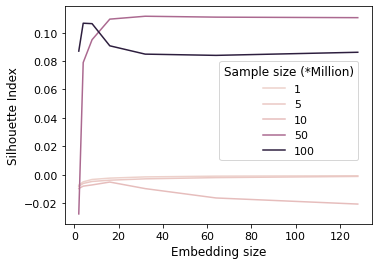

In [27]:
fig = plt.figure(figsize=(5.5,4))
ax = sns.lineplot(x="d", y="SI", hue="s", data=SI_df)
ax.set_xlabel('Embedding size', size = 12)
ax.set_ylabel('Silhouette Index', size = 12)
plt.legend(fontsize=11, title='Sample size (*Million)', title_fontsize = 12, 
           loc = 'center', bbox_to_anchor = [0.73, 0.52])
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
fig.savefig(os.path.join('results/', "hyper_d_s.png"), 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)

In [31]:
final_emb = pd.read_csv('../../data/K562/hg19/res100000_datasets/embeddings/oe_processed/oe_d8_s50_o2.txt', sep = '\t')

In [32]:
final_emb

,index,chr_name,pos,emb1,emb2,emb3,emb4,emb5,emb6,emb7,emb8,HMM_structural
0,0,chr1,5,0.975697,0.150678,1.103918,0.215091,-0.409760,0.337454,-0.097898,-0.435049,4
1,1,chr1,7,0.727818,0.350172,0.851716,-0.263199,-0.776725,0.520543,0.160580,-0.456772,2
2,2,chr1,8,1.817987,0.263212,1.709721,0.457461,-0.716400,0.543875,-0.385147,-0.749001,4
3,3,chr1,9,1.732828,0.227901,1.620914,0.523177,-0.685176,0.556946,-0.401460,-0.698903,4
4,4,chr1,10,1.826129,0.405289,1.693102,0.508932,-0.774971,0.591531,-0.486529,-0.729199,4
...,...,...,...,...,...,...,...,...,...,...,...,...
25598,25598,chr22,508,1.556921,0.303619,1.518419,0.499486,-0.571278,0.438110,-0.368162,-0.664690,4
25599,25599,chr22,509,1.704541,0.210547,1.524580,0.560643,-0.625352,0.527565,-0.470710,-0.764569,4
25600,25600,chr22,510,1.779116,0.216830,1.752489,0.479899,-0.574768,0.560206,-0.392777,-0.737621,4
25601,25601,chr22,511,1.597099,0.139186,1.615240,0.472655,-0.556561,0.480034,-0.327883,-0.653598,4
